In [1]:
!pip install numpy_groupies
!pip install xrft==0.4.0

  Using cached numpy_groupies-0.9.14-py3-none-any.whl
  Using cached xrft-0.4.0-py2.py3-none-any.whl (31 kB)
  Attempting uninstall: xrft
    Found existing installation: xrft 0.3.0
    Uninstalling xrft-0.3.0:
      Successfully uninstalled xrft-0.3.0


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42765")
client

<Client: 'tcp://127.0.0.1:42765' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:35145' processes=2 threads=16, memory=58.99 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
# plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
for entry in params_dict.keys():
    print(f"{entry} parameters and their allowable args are:")
    description = cat[entry].describe()
    params = description["user_parameters"]
    if len(params) != 0:
        for i in range(len(params)):
            print(f"""    {params[i]["name"]}: {params[i]["allowed"]}""")            
    else:
        print("    Not implemented.")
    print()

GIGATL parameters and their allowable args are:
    region: ['1', '2']
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

HYCOM50 parameters and their allowable args are:
    region: ['1_GS', '2_GE', '3_MD']
    datatype: ['surf', 'int', 'int_wvel', 'grid']
    season: ['fma', 'aso', '']
    grid: ['grid', '']

eNATL60 parameters and their allowable args are:
    region: ['1', '2', '3']
    datatype: ['surface_hourly', 'interior_daily']
    season: ['fma', 'aso']

FESOM parameters and their allowable args are:
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

ORCA36 parameters and their allowable args are:
    region: ['1', '2', '3', '4']
    datatype: ['surface_hourly', 'interior_daily', 'grid']
    season: ['fma', 'aso', '']
    grid: ['bathymetry', 'meshmask', '']



# Load data

In [7]:
enatlw = cat.eNATL60(region='1',datatype='surface_hourly', season='fma'
                    ).to_dask().isel(y=slice(None,660),x=slice(210,None))

In [9]:
hycomw = cat.HYCOM50(region='1_GS', datatype='surf', season='fma', decode_times=False).to_dask()
hycom_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()

In [47]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
    
gigaw = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='fma'
                                ).to_dask()
                     ).isel(eta_rho=slice(80,980),xi_rho=slice(700,None),
                            eta_v=slice(81,980),xi_u=slice(700,None))

In [11]:
fesomw = cat.FESOM(datatype='surf', season='fma').to_dask()

In [12]:
orcaw = cat.ORCA36(region='1', datatype='surface_hourly', season='fma').to_dask()
orca_grid = cat.ORCA36(region='1', datatype='grid',grid='meshmask').to_dask()

In [13]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()

istart = 497664
di = 144
iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)

llcw = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                         iters=iters,
                         type='latlon').sel(
#                                               time=slice('2012-02-01','2012-04-30'),
                                            j=slice(9555,10198),j_g=slice(9555,10198),
                                            i=slice(15355,15845),i_g=slice(15355,15845),
                                           ).chunk({'j':200,'j_g':200,
                                                    'i':200,'i_g':200}
                                                  )

In [14]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridllc = Grid(llcw, periodic=[],
               coords={'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )
gridllc

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   k --> outer
  * outer    k_p1 --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

In [15]:
llcfC = xr.apply_ufunc(gsw.f,llcw.YC,dask='parallelized')
llcfG = xr.apply_ufunc(gsw.f,llcw.YG,dask='parallelized')
llcfG

<xarray.DataArray 'YG' (j_g: 644, i_g: 491)>
dask.array<transpose, shape=(644, 491), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 15355 15356 15357 15358 ... 15842 15843 15844 15845
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
    rAz      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>

# Vorticity and strain

In [8]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def nemo_vort(u, v, e1f, e2f, e2v, e1u):
    return (
        diff(v * e2v, 1, axis=-1)
        - diff(u * e1u, 1, axis=-2)
    ) / (e1f  * e2f)

def nemo_div(u, v, e1t, e2t, e1v, e2u):
    return (
        diff(v * e1v, 1, axis=-2)
        + diff(u * e2u, 1, axis=-1)
    ) / (e1t  * e2t)

def nemo_str(u, v, e1t, e2t, e2u, e1v, e1f, e2f, e1u, e2v):
    str1 = (diff(u * e2u, 1, axis=-1)
            - diff(v * e1v, 1, axis=-2)
           ) / (e1t  * e2t)
    str2 = (diff(u * e1u, 1, axis=-2)
            + diff(v * e2v, 1, axis=-1)
           ) / (e1f  * e2f)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

def t_to_f(da):
    return (.25*(da 
                + np.roll(da,1,-1) 
                + np.roll(da,1,-2)
                + np.roll(np.roll(da,1,-1),1,-2)
               )
    )

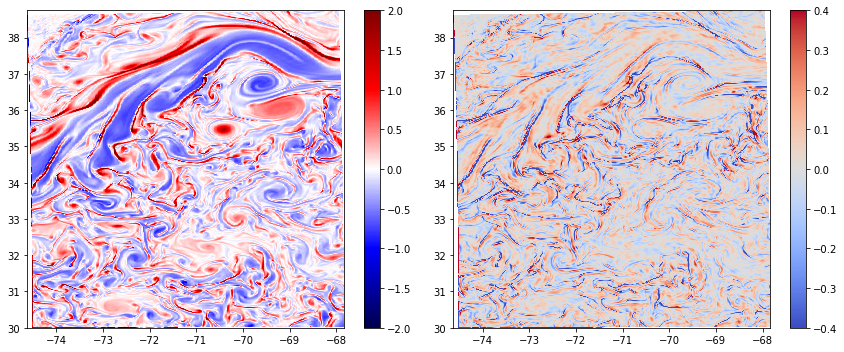

In [9]:
enatlf = xr.apply_ufunc(gsw.f, enatlw.lat, dask='parallelized')

vorenatlw = xr.apply_ufunc(
    nemo_vort,
    enatlw.sozocrtx, 
    enatlw.somecrty, 
    enatlw.e1f, enatlw.e2f,
    enatlw.e2v, enatlw.e1u,
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatlw.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divenatlw = xr.apply_ufunc(
    nemo_div,
    enatlw.sozocrtx, 
    enatlw.somecrty, 
    enatlw.e1t, enatlw.e2t,
    enatlw.e1v, enatlw.e2u,
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatlw.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(enatlw.lon, enatlw.lat, vorenatlw.isel(time_counter=0)/enatlf, 
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True, shading='auto'
                    )
im2 = ax2.pcolormesh(enatlw.lon, enatlw.lat, divenatlw.isel(time_counter=0)/enatlf, 
                     cmap='coolwarm', vmax=.4, vmin=-.4, rasterized=True, shading='auto'
                    )

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

/tmp/ipykernel_20808/672622114.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolor(orcaw.nav_lon.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)),
/tmp/ipykernel_20808/672622114.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolor(orcaw.nav_lon.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)),


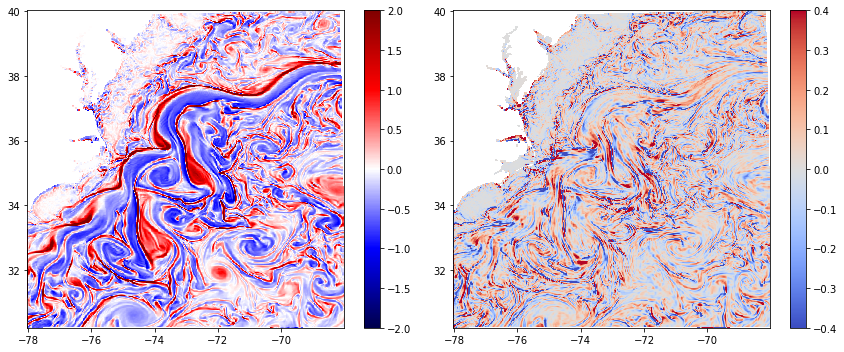

In [21]:
orcaf = xr.apply_ufunc(gsw.f, orcaw.nav_lat, dask='parallelized')

vororcaw = xr.apply_ufunc(
    nemo_vort,
    orcaw.uos.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orcaw.vos.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca_grid.e1f.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca_grid.e2f.where(orca_grid.fmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca_grid.e2v.where(orca_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca_grid.e1u.where(orca_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orcaw.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divorcaw = xr.apply_ufunc(
    nemo_div,
    orcaw.uos.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orcaw.vos.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
    orca_grid.e1t.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca_grid.e2t.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    orca_grid.e1v.where(orca_grid.vmask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0), 
    orca_grid.e2u.where(orca_grid.umask.isel(time_counter=0,nav_lev=0)!=0.).isel(time_counter=0),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[orcaw.uos.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('div')


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.set_tight_layout(True)

im1 = ax1.pcolor(orcaw.nav_lon.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 orcaw.nav_lat.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 (vororcaw.isel(time_counter=0)
                  / orcaf.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.)
                 ).isel(y=slice(None,450)), 
                 cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolor(orcaw.nav_lon.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 orcaw.nav_lat.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.).isel(y=slice(None,450)), 
                 (divorcaw.isel(time_counter=0)
                  / orcaf.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.)
                 ).isel(y=slice(None,450)), 
                 cmap='coolwarm', vmax=.4, vmin=-.4, rasterized=True)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

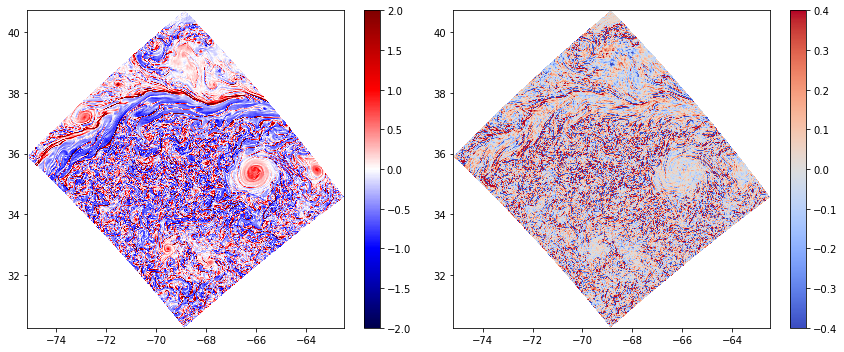

In [49]:
gridg = gigaw.attrs["xgcm-Grid"]

mask_rho = gigaw.salt.where(gigaw.salt==0.).isel(time=0)
mask_u = gridg.interp(mask_rho, 'xi')
mask_v = gridg.interp(mask_rho, 'eta')
mask_psi = gridg.interp(gridg.interp(mask_rho, 'eta'), 'xi')

gigaf = gridg.interp(gridg.interp(gigaw.f, 'eta'), 'xi')


pm_psi = gridg.interp(gridg.interp(gigaw.pm, 'eta'), 'xi') # at psi points (eta_v, xi_u) 
pn_psi = gridg.interp(gridg.interp(gigaw.pn, 'xi'), 'eta') # at psi points (eta_v, xi_u)

dudy = gridg.diff(gigaw.u.where(mask_u!=0.), 'eta') * pn_psi
dudx = gridg.diff(gigaw.u.where(mask_u!=0.), 'xi', boundary='extend') * gigaw.pm
dvdx = gridg.diff(gigaw.v.where(mask_v!=0.), 'xi') * pm_psi
dvdy = gridg.diff(gigaw.v.where(mask_v!=0.), 'eta', boundary='extend') * gigaw.pn


vorgigaw = (dvdx - dudy).rename('vort')
divgigaw = (dudx + dvdy).rename('div')


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(gigaw.lon, gigaw.lat, vorgigaw.isel(time=0)/gigaf,
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True, shading='auto')
im2 = ax2.pcolormesh(gigaw.lon, gigaw.lat, 
                     gridg.interp(gridg.interp(divgigaw.isel(time=0),'xi'),'eta')/gigaf, 
                     cmap='coolwarm', vmax=.4, vmin=-.4, rasterized=True, shading='auto')

# ax1.set_xlim([-78,-68])
# ax1.set_ylim([30,40])
# ax2.set_xlim([-78,-68])
# ax2.set_ylim([30,40])

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [25]:
Ny = len(hycom_grid.lat)
Nx = len(hycom_grid.lon)
import gsw
xx, yy = np.meshgrid(hycom_grid.longitude, hycom_grid.latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

hycomw.coords['dx'] = (('lat','lon'), dx.data)
hycomw.coords['dy'] = (('lat','lon'), dy.data)

In [26]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def t_vort(u, v, dx, dy):
    return (
        diff(v * dy, 1, axis=-1)
        - diff(u * dx, 1, axis=-2)
    ) / (dx * dy)

def t_div(u, v, dx, dy):
    return (
        diff(v * dx, 1, axis=-2)
        + diff(u * dy, 1, axis=-1)
    ) / (dx * dy)

def t_str(u, v, dx, dy):
    str1 = (diff(u * dy, 1, axis=-1)
            - diff(v * dx, 1, axis=-2)
           ) / (dy * dx)
    str2 = (diff(u * dx, 1, axis=-2)
            + diff(v * dy, 1, axis=-1)
           ) / (dy * dx)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

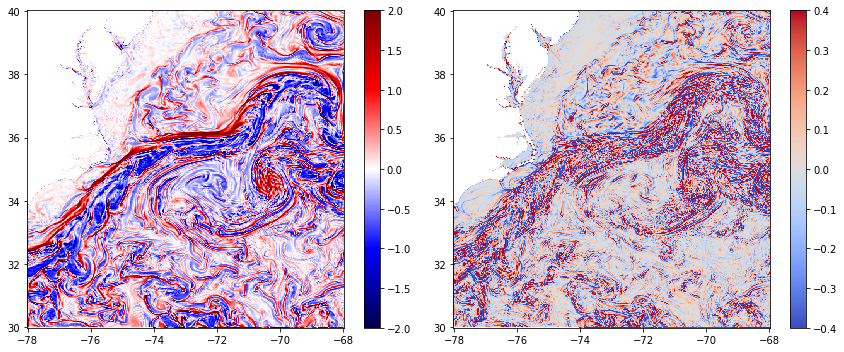

In [28]:
hycomf = xr.apply_ufunc(gsw.f, hycomw.latitude, dask='parallelized')

vorhycomw = xr.apply_ufunc(
    t_vort,
    hycomw.uu1, 
    hycomw.vv1, 
    hycomw.dx, hycomw.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycomw.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divhycomw = xr.apply_ufunc(
    t_div,
    hycomw.uu1, 
    hycomw.vv1, 
    hycomw.dx, hycomw.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycomw.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('div')


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(hycom_grid.longitude, hycom_grid.latitude, 
                     vorhycomw.isel(time=0)/hycomf, cmap='seismic', vmax=2, vmin=-2,
                     rasterized=True, shading='auto')
im2 = ax2.pcolormesh(hycom_grid.longitude, hycom_grid.latitude, 
                     divhycomw.isel(time=0)/hycomf, cmap='coolwarm', vmin=-.4, vmax=.4,
                     rasterized=True, shading='auto')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [30]:
Ny = len(fesomw.lat)
Nx = len(fesomw.lon)
import gsw
xx, yy = np.meshgrid(fesomw.lon, fesomw.lat)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

fesomw.coords['dx'] = (('lat','lon'), dx.data)
fesomw.coords['dy'] = (('lat','lon'), dy.data)

fesomw

<xarray.Dataset>
Dimensions:  (lat: 1000, lon: 1000, time: 2160)
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
    dx       (lat, lon) float64 963.9 963.9 963.9 963.9 ... 852.7 852.7 852.7
    dy       (lat, lon) float64 1.113e+03 1.113e+03 ... 1.113e+03 1.113e+03
Data variables:
    dflux    (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    ssh      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    sss      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    sst      (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    tx_sur   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    ty_sur   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    u_surf   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    v_surf   (time, lat, lon) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>

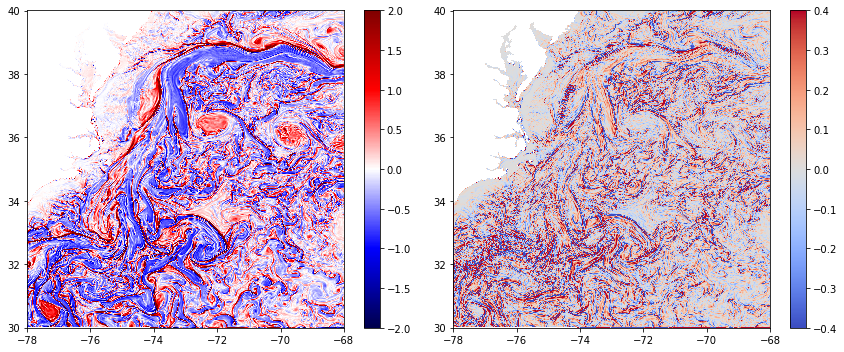

In [31]:
fesomf = xr.apply_ufunc(gsw.f, fesomw.lat, dask='parallelized')

vorfesomw = xr.apply_ufunc(
    t_vort,
    fesomw.u_surf, 
    fesomw.v_surf, 
    fesomw.dx, fesomw.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesomw.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divfesomw = xr.apply_ufunc(
    t_div,
    fesomw.u_surf, 
    fesomw.v_surf, 
    fesomw.dx, fesomw.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[fesomw.u_surf.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('div')


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(fesomw.lon, fesomw.lat, 
                     vorfesomw.isel(time=0)/fesomf, cmap='seismic', vmax=2, vmin=-2,
                     rasterized=True, shading='auto')
im2 = ax2.pcolormesh(fesomw.lon, fesomw.lat, 
                     divfesomw.isel(time=0)/fesomf, cmap='coolwarm', vmin=-.4, vmax=.4,
                     rasterized=True, shading='auto')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

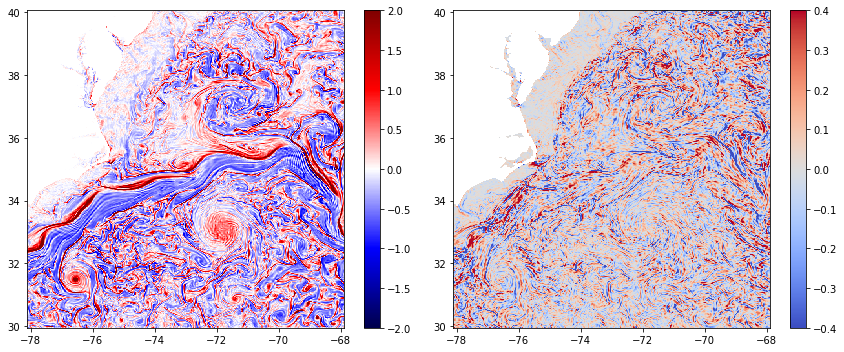

In [32]:
vorllcw = ((gridllc.diff(llcw.V * llcw.dyC,'X',boundary='extend') 
             - gridllc.diff(llcw.U * llcw.dxC,'Y',boundary='extend')
            ) / llcw.rAz
          ).isel(k=0).reset_coords(drop=True).chunk({'j_g':200,'i_g':200}).rename('vort')

divllcw = ((gridllc.diff(llcw.V * llcw.dxG,'Y',boundary='extend') 
            + gridllc.diff(llcw.U * llcw.dyG,'X',boundary='extend')
           ) / llcw.rA
          ).isel(k=0).reset_coords(drop=True).chunk({'j':200,'i':200}).rename('div')


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(llcw.XG, llcw.YG, vorllcw.isel(time=0)/llcfG, cmap='seismic', vmax=2, vmin=-2,
                     rasterized=True, shading='auto')
im2 = ax2.pcolormesh(llcw.XG, llcw.YG, 
                     gridllc.interp(gridllc.interp(divllcw.isel(time=0),'Y',boundary='extend'),
                                    'X',boundary='extend')/llcfG, 
                     cmap='coolwarm', vmax=.4, vmin=-.4,
                     rasterized=True, shading='auto')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

# Assume local Cartesian plane

In [30]:
Ny = len(enatlw.y)
Nx = len(enatlw.x)
dx = enatlw.e1t.mean(skipna=True)
dy = enatlw.e2t.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kenatl = 1/(2*dy)
else:
    Kenatl = 1/(2*dx)
    
zeta_enatlw = xr.DataArray(.25*((vorenatlw + np.roll(vorenatlw,1,-1)
                                 + np.roll(vorenatlw,1,-2)
                                 + np.roll(vorenatlw,1,(-1,-2))
                                ) / enatlf).data, dims=['time','YC','XC'],
                           coords={'time':np.arange(len(enatlw.time_counter))*3600,
                                   'YC':np.arange(0,Ny*dy,dy),
                                   'XC':np.arange(0,Nx*dx,dx)[:-1]}
                          ).chunk({'time':100})
delta_enatlw = xr.DataArray((divenatlw / enatlf).data, dims=['time','YC','XC'],
                            coords={'time':np.arange(len(enatlw.time_counter))*3600,
                                    'YC':np.arange(0,Ny*dy,dy),
                                    'XC':np.arange(0,Nx*dx,dx)[:-1]}
                           ).chunk({'time':100})

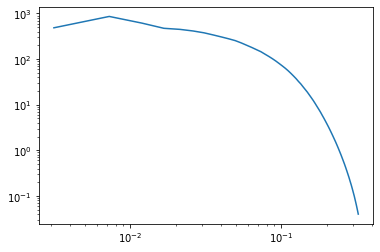

In [36]:
Szeta = xrft.isotropic_power_spectrum(zeta_enatlw, dim=['YC','XC'], detrend='linear', 
                                      window='hann', window_correction=True, 
                                      true_phase=True, true_amplitude=True,
                                      truncate=True).mean('time',skipna=True)

fig, ax = plt.subplots()
ax.plot(Szeta.freq_r*1e3, Szeta)
ax.set_xscale('log')
ax.set_yscale('log')

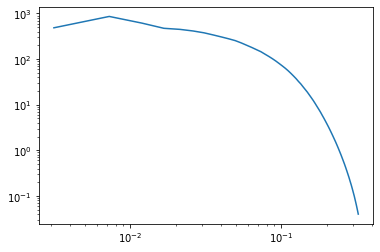

In [37]:
Sdelta = xrft.isotropic_power_spectrum(delta_enatlw, dim=['YC','XC'], detrend='linear', 
                                       window='hann', window_correction=True, 
                                       true_phase=True, true_amplitude=True,
                                       truncate=True).mean('time',skipna=True)

fig, ax = plt.subplots()
ax.plot(Sdelta.freq_r*1e3, Szeta)
ax.set_xscale('log')
ax.set_yscale('log')

In [52]:
Ny = len(gigaw.eta_rho)
Nx = len(gigaw.xi_rho)
dx = (gigaw.pm**-1).mean(skipna=True)
dy = (gigaw.pn**-1).mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kgigatl = 1/(2*dy)
else:
    Kgigatl = 1/(2*dx)
    
zeta_gigaw = xr.DataArray(gridg.interp(gridg.interp(vorgigaw,'eta',boundary='extend'),
                                       'xi',boundary='extend').data, 
                          dims=['time','YC','XC'],
                          coords={'time':np.arange(len(gigaw.time))*3600,
                                  'YC':np.arange(0,(Ny)*dy,dy),
                                  'XC':np.arange(0,(Nx)*dx,dx)}
                         ).chunk({'time':100,'YC':-1,'XC':-1})
delta_gigaw = xr.DataArray(divgigaw.data, dims=['time','YC','XC'],
                           coords={'time':np.arange(len(gigaw.time))*3600,
                                   'YC':np.arange(0,(Ny)*dy,dy),
                                   'XC':np.arange(0,(Nx)*dx,dx)}
                          ).chunk({'time':100,'YC':-1,'XC':-1})

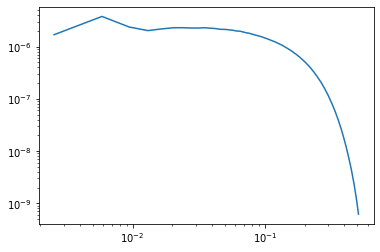

In [53]:
Szeta = xrft.isotropic_power_spectrum(zeta_gigaw, dim=['YC','XC'], detrend='linear', 
                                      window='hann', window_correction=True, 
                                      true_phase=True, true_amplitude=True,
                                      truncate=True).mean('time',skipna=True)

fig, ax = plt.subplots()
ax.plot(Szeta.freq_r*1e3, Szeta)
ax.set_xscale('log')
ax.set_yscale('log')

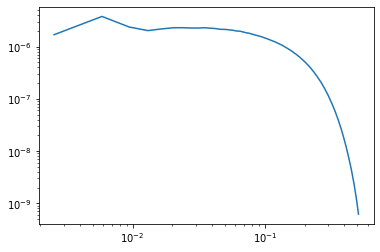

In [54]:
Sdelta = xrft.isotropic_power_spectrum(delta_gigaw, dim=['YC','XC'], detrend='linear', 
                                       window='hann', window_correction=True, 
                                       true_phase=True, true_amplitude=True,
                                       truncate=True).mean('time',skipna=True)

fig, ax = plt.subplots()
ax.plot(Sdelta.freq_r*1e3, Szeta)
ax.set_xscale('log')
ax.set_yscale('log')

In [33]:
Fzeta_enatlw = xrft.fft(xrft.fft(zeta_enatlw.fillna(0.), 
                                 dim=['YC','XC'], window='hann', detrend='constant', 
                                 true_phase=True, true_amplitude=True
                                ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                        dim=['time'], window='hann', detrend='constant', 
                        true_phase=True, true_amplitude=True
                       )
Fzeta_enatlw = Fzeta_enatlw.isel(freq_time=slice(len(Fzeta_enatlw.freq_time)//2,None)) * 2

Fdelta_enatlw = xrft.fft(xrft.fft(delta_enatlw.fillna(0.), 
                                  dim=['YC','XC'], window='hann', detrend='constant', 
                                  true_phase=True, true_amplitude=True
                                 ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                         dim=['time'], window='hann', detrend='constant', 
                         true_phase=True, true_amplitude=True
                        )
Fdelta_enatlw = Fdelta_enatlw.isel(freq_time=slice(len(Fdelta_enatlw.freq_time)//2,None)) * 2

In [55]:
Fzeta_gigaw = xrft.fft(xrft.fft(zeta_gigaw.fillna(0.), 
                                dim=['YC','XC'], window='hann', detrend='constant', 
                                true_phase=True, true_amplitude=True
                               ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                       dim=['time'], window='hann', detrend='constant', 
                       true_phase=True, true_amplitude=True
                      )
Fzeta_gigaw = Fzeta_gigaw.isel(freq_time=slice(len(Fzeta_gigaw.freq_time)//2,None)) * 2

Fdelta_gigaw = xrft.fft(xrft.fft(delta_gigaw.fillna(0.), 
                                 dim=['YC','XC'], window='hann', detrend='constant', 
                                 true_phase=True, true_amplitude=True
                                ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                        dim=['time'], window='hann', detrend='constant', 
                        true_phase=True, true_amplitude=True
                       )
Fdelta_gigaw = Fdelta_gigaw.isel(freq_time=slice(len(Fdelta_gigaw.freq_time)//2,None)) * 2

# Function to isotropize the FFT

In [16]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. "
            + "Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


def isotropize(ps, fftdim, nfactor=4, **kwargs):
    """
    Isotropize a 2D power spectrum or cross spectrum
    by taking an azimuthal average.
    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    where :math:`N` is the number of azimuthal bins.
    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.
    """

    # compute radial wavenumber bins
    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    nbins = int(min(N) / nfactor)
    freq_r = np.sqrt(k ** 2 + l ** 2).rename("freq_r")
    kr = _groupby_bins_agg(freq_r, freq_r, bins=nbins, func="mean")

    if "truncate" in kwargs:
        if truncate:
            if k.max() > l.max():
                kmax = l.max()
            else:
                kmax = k.max()
            kr = kr.where(kr <= kmax)
        else:
            pass

    iso_ps = (
        _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean")
        .rename({"freq_r_bins": "freq_r"})
        .drop_vars("freq_r")
    )
    iso_ps.coords["freq_r"] = kr.data
    if "truncate" in kwargs:
        if truncate:
            return (iso_ps * iso_ps.freq_r).dropna("freq_r")
    else:
        return iso_ps * iso_ps.freq_r

In [58]:
def density(ps, dim):
    ff = np.prod([float(ps[d].spacing) for d in dim])
    return ps * ff

In [59]:
isoFalpha_enatlw = isotropize(density(np.abs(Falpha_enatlw.chunk({'freq_time':10}))**2,
                                      ['freq_time','freq_YC','freq_XC']), 
                              ['freq_YC','freq_XC'], nfactor=4, 
                              kwargs={'truncate':True}
                             ).compute() 
isoFdelta_enatlw = isotropize(density(np.abs(Fdelta_enatlw.chunk({'freq_time':10}))**2,
                                      ['freq_time','freq_YC','freq_XC']),  
                              ['freq_YC','freq_XC'], nfactor=4, 
                              kwargs={'truncate':True}
                             ).compute()

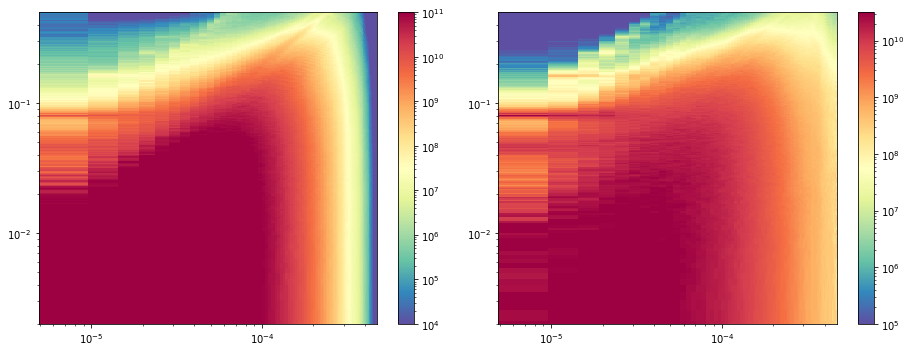

In [85]:
fig, axes = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax00 = axes[0]
ax01 = axes[1]


im0 = ax00.pcolormesh(isoFalpha_enatlw.freq_r.isel(freq_r=slice(1,None)),
                      isoFalpha_enatlw.freq_time.isel(freq_time=slice(1,None))*3600,
                      (isoFalpha_enatlw.isel(freq_r=slice(1,None),freq_time=slice(1,None)))*60*3600, 
                      cmap='Spectral_r', 
                      norm=clr.LogNorm(vmin=1e4, vmax=1e11), 
                      shading='auto', rasterized=True)
im1 = ax01.pcolormesh(isoFdelta_enatlw.freq_r.isel(freq_r=slice(1,None)),
                      isoFdelta_enatlw.freq_time.isel(freq_time=slice(1,None))*3600,
                      (isoFdelta_enatlw.isel(freq_r=slice(1,None),freq_time=slice(1,None)))*60*3600, 
                      cmap='Spectral_r', 
                      norm=clr.LogNorm(vmin=1e5, vmax=10**10.5), 
                      shading='auto', rasterized=True)

ax00.set_xscale('log')
ax00.set_yscale('log')
ax01.set_xscale('log')
ax01.set_yscale('log')

ax00.set_ylim([2e-3,None])
ax01.set_ylim([2e-3,None])
fig.colorbar(im0, ax=ax00)
fig.colorbar(im1, ax=ax01)

In [63]:
isoFzeta_gigaw = isotropize(density(np.abs(Fzeta_gigaw.chunk({'freq_time':10}))**2,
                                     ['freq_time','freq_YC','freq_XC']),  
                            ['freq_YC','freq_XC'], nfactor=4, 
                            kwargs={'truncate':True}
                           ).compute() 
isoFdelta_gigaw = isotropize(density(np.abs(Fdelta_gigaw.chunk({'freq_time':10}))**2,
                                     ['freq_time','freq_YC','freq_XC']), 
                             ['freq_YC','freq_XC'], nfactor=4, 
                             kwargs={'truncate':True}
                            ).compute() 

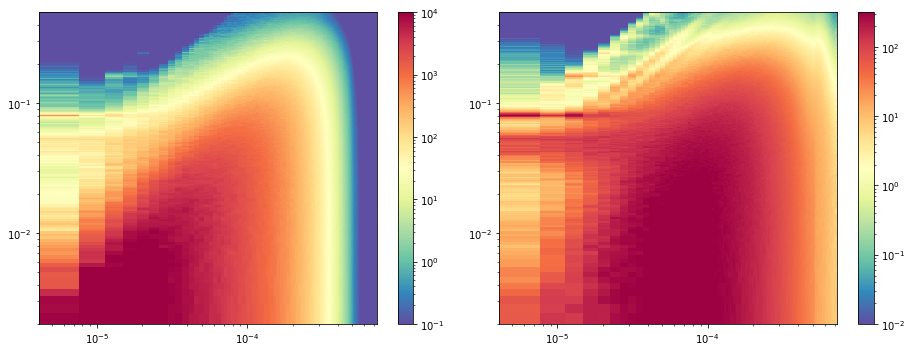

In [79]:
fig, axes = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax00 = axes[0]
ax01 = axes[1]


im0 = ax00.pcolormesh(isoFzeta_gigaw.freq_r.isel(freq_r=slice(1,None)),
                      isoFzeta_gigaw.freq_time.isel(freq_time=slice(1,None))*3600,
                      (isoFzeta_gigaw.isel(freq_r=slice(1,None),freq_time=slice(1,None)))*60*3600, 
                      cmap='Spectral_r', 
                      norm=clr.LogNorm(vmin=1e-1, vmax=1e4), 
                      shading='auto', rasterized=True)
im1 = ax01.pcolormesh(isoFdelta_gigaw.freq_r.isel(freq_r=slice(1,None)),
                      isoFdelta_gigaw.freq_time.isel(freq_time=slice(1,None))*3600,
                      (isoFdelta_gigaw.isel(freq_r=slice(1,None),freq_time=slice(1,None)))*60*3600, 
                      cmap='Spectral_r', 
                      norm=clr.LogNorm(vmin=1e-2, vmax=10**2.5), 
                      shading='auto', rasterized=True)

ax00.set_xscale('log')
ax00.set_yscale('log')
ax01.set_xscale('log')
ax01.set_yscale('log')

ax00.set_ylim([2e-3,None])
ax01.set_ylim([2e-3,None])
fig.colorbar(im0, ax=ax00)
fig.colorbar(im1, ax=ax01)

In [ ]:
client.close()